# Clasificación con clases desbalanceadas

En las tareas de clasificación supervisada, buscamos que mediante los ejemplos etiquetados las máquinas puedan aprender los atributos inherentes a las distintas clases. Sin embargo, en muchos casos reales de clasificación, la cantidad de ejemplos de cada clase son muy dispares, en cuyo caso hablamos de clases desbalanceadas. Si uno no aplica estrategias para compensar este problema, la máquina aprenderá muy bien las características de la clase más representada, pero no logrará extraer información generalizable de las clases menos representadas. Además, debemos tener cuidado al momento de interpretar las distintas métricas a las cuales tenemos acceso, pues debemos tomar en cuenta el balance de las clases y la naturaleza del problema para evaluar realmente qué tan bueno es el desempeño.

<img src="https://s-media-cache-ak0.pinimg.com/564x/cb/cb/41/cbcb41cb2c1db6c32c1e869be2172c3b.jpg"  style="width:8cm;"  />

Para esta parte de la tarea utilizaremos el siguiente dataset publicado en Kaggle: https://www.kaggle.com/zhangjuefei/birds-bones-and-living-habits/data#. Este conjunto de datos contiene 419 pájaros caracterizados con 10 atributos y clasificados según su grupo ecológico. Leer la página Kaggle del dataset para mayor información.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
#%cd 'gdrive'
#%cd 'My Drive/Tarea 3/Problema 2'
%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Tarea 3/Problema 2'

### Paquetes a Utilizar

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from keras.layers import Dense
from keras.models import Sequential
import seaborn as sns    
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

**2.a Carga de datos** 

i) Descargue los datos y cárguelos usando pandas, elimine los datos con valor NaN. Haga una exploración rápida de los datos. ¿Cuántas clases hay?¿Cómo se reparten?¿Son las clases desbalanceadas efectivamente?

In [33]:
# Cargar datos y eliminar datos NaN
df     = pd.read_csv("datasets_675_1284_bird.csv").dropna()

# Se buscan la cantidad de clases y los ejemplos de cada clase
clases = pd.DataFrame({'id':df['id'],'Class':df['type']}).groupby('Class')['id'].nunique()

df        = df.drop(df.columns[0], axis = 1)                  # Elimina la columna de index
atributes = df.iloc[:,:-1].columns                            # Atributos

print(clases)

Class
P      38
R      48
SO    124
SW    116
T      23
W      64
Name: id, dtype: int64


**¿Cuantas clases hay?**

Existe 6 clases que corresponde a P, R, SO, SW, T, R

**¿Cómo se reparten?¿Son las clases desbalanceadas efectivamente?**

Estas se encuentran distribuidas de forma desbalanceadas dado que existe una cantidad mayor de las clases SO y SW en comparación de las demás clases.

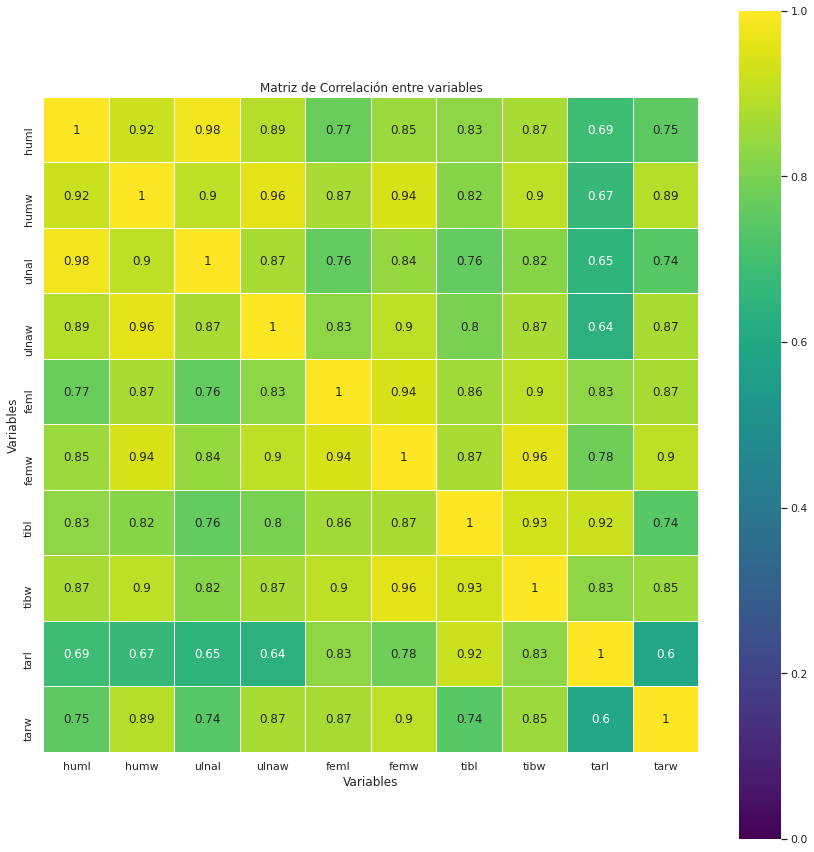

In [26]:
# Gráfico de Matriz de Correlación entre atributos
plt.figure(figsize=(12,12))          

# Matriz de Correlación
sns.heatmap(np.around(df.iloc[:,:-1].corr(),decimals=2),
            vmax=1,vmin=0, linewidths=0.1,square=True,
            annot=True,cmap='viridis',linecolor="white")
plt.tight_layout()
plt.ylabel('Variables')
plt.xlabel('Variables')
plt.title('Matriz de Correlación entre variables');
plt.show()

**Comentarios:**

Se puede ver una alta correlación entre los atributos, es más, en casi todos los casos la correlación es mayor a 0.5, con lo cual se puede concluir lo anterior.

ii) Separe la data según su clase. Grafique los atributos para cada clase y compare

In [34]:
types = np.asarray(df.type.drop_duplicates())     # Tipos de clases
X,Y = [], []                                      # Lista para almacenar

# Esta función almacena los diferentes atributos para cada clase
for i in types:                             
  XY = df.loc[(df.type == i),:]
  X.append(XY.drop(["type"],axis = 1))    # Se agrega los atributos de cada clase
  Y.append(XY["type"])                    # Se agrega las clases

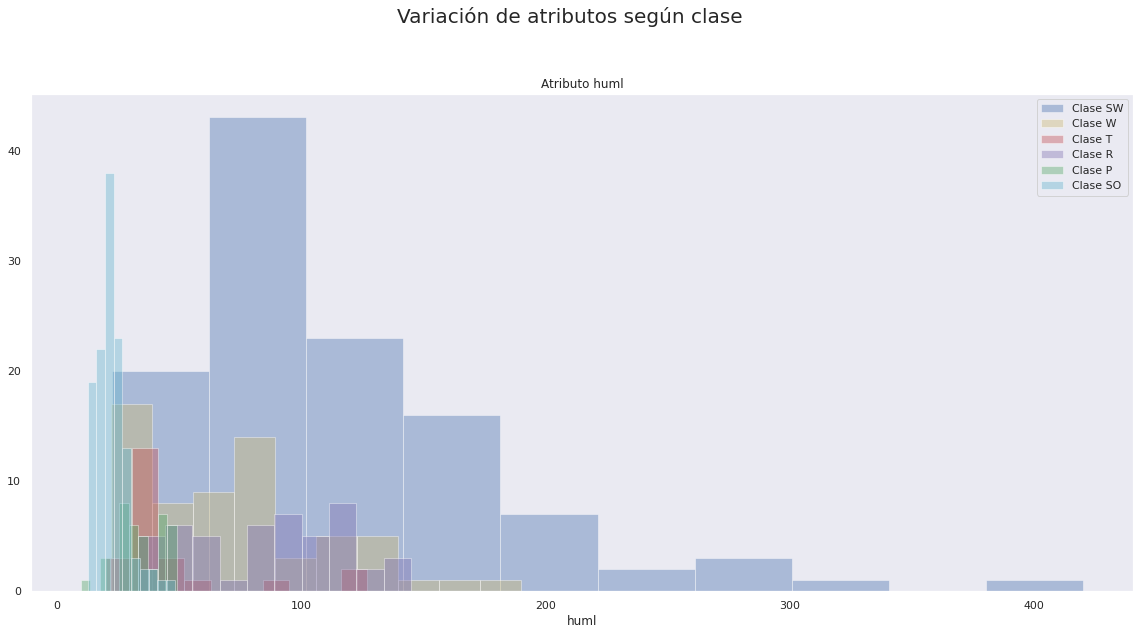

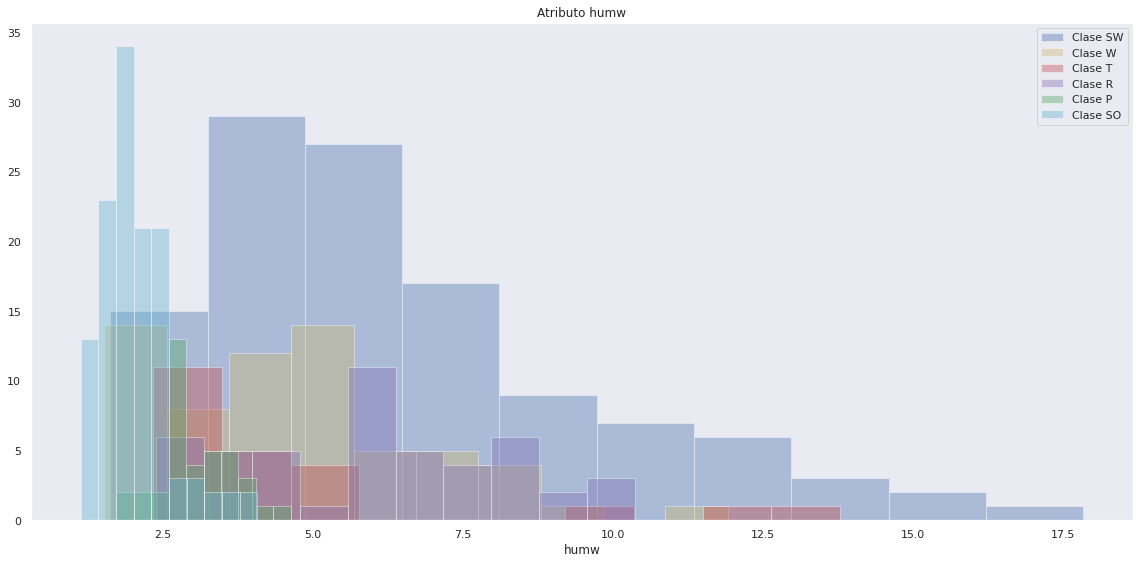

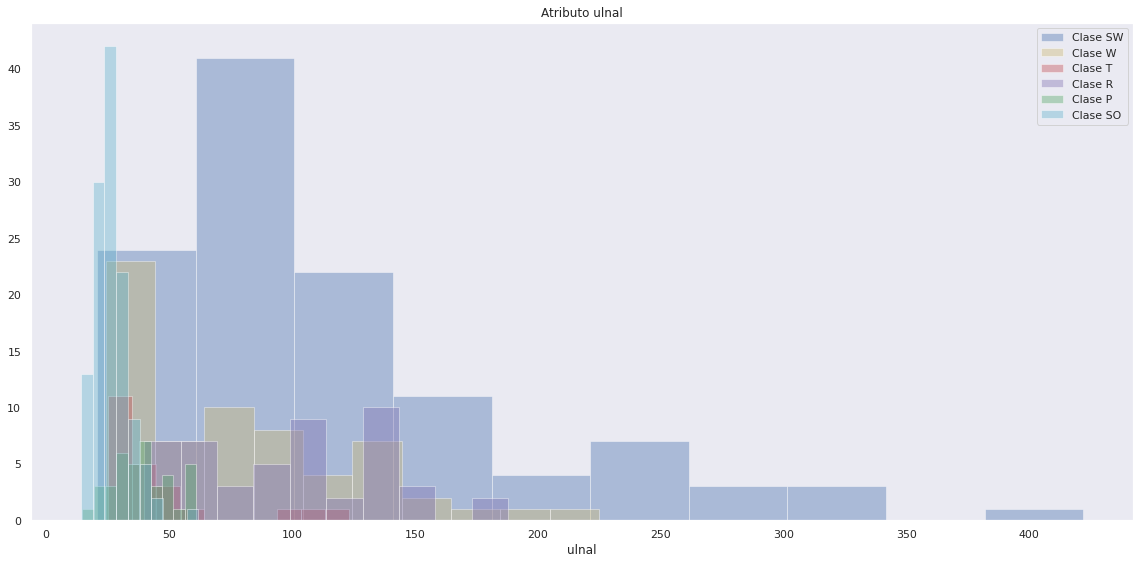

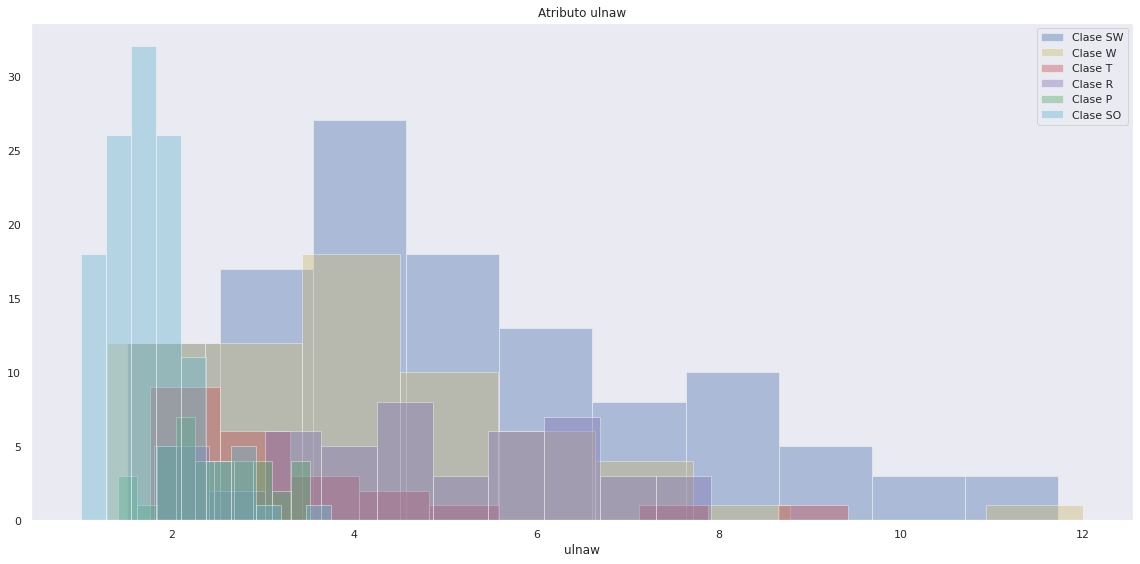

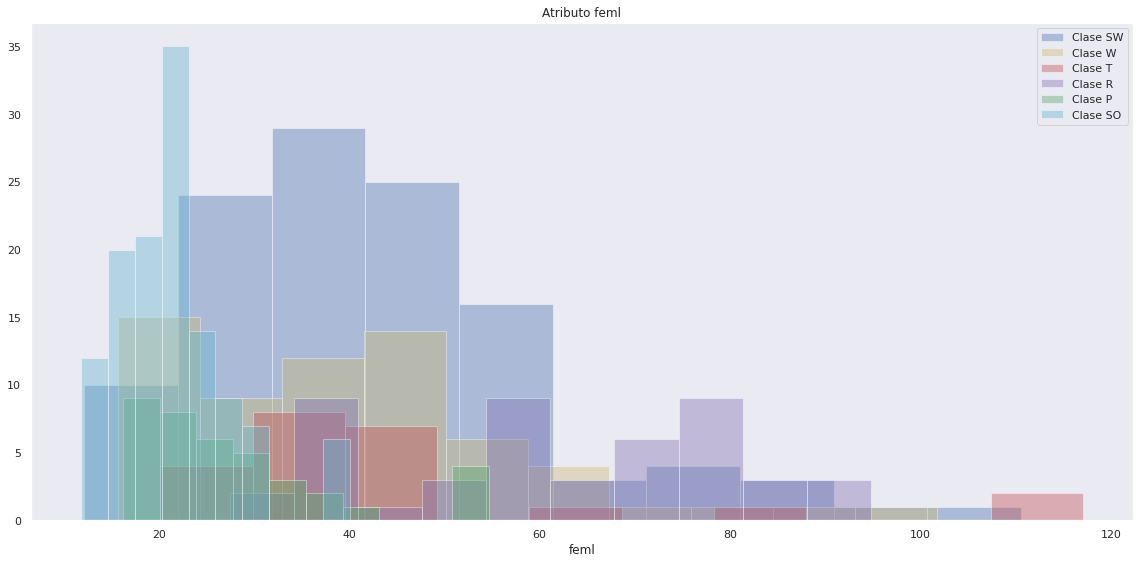

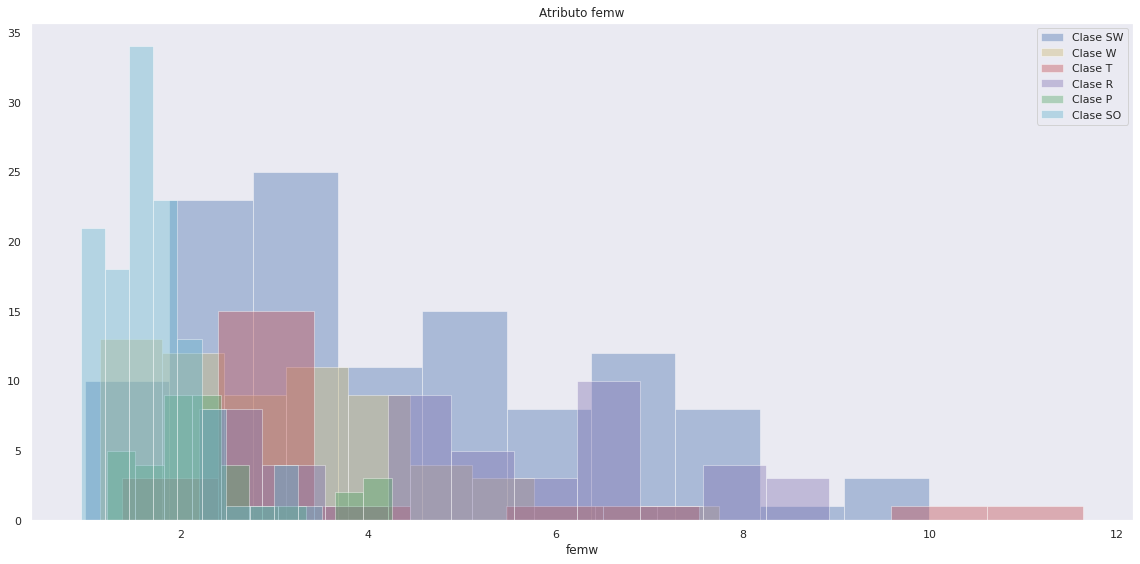

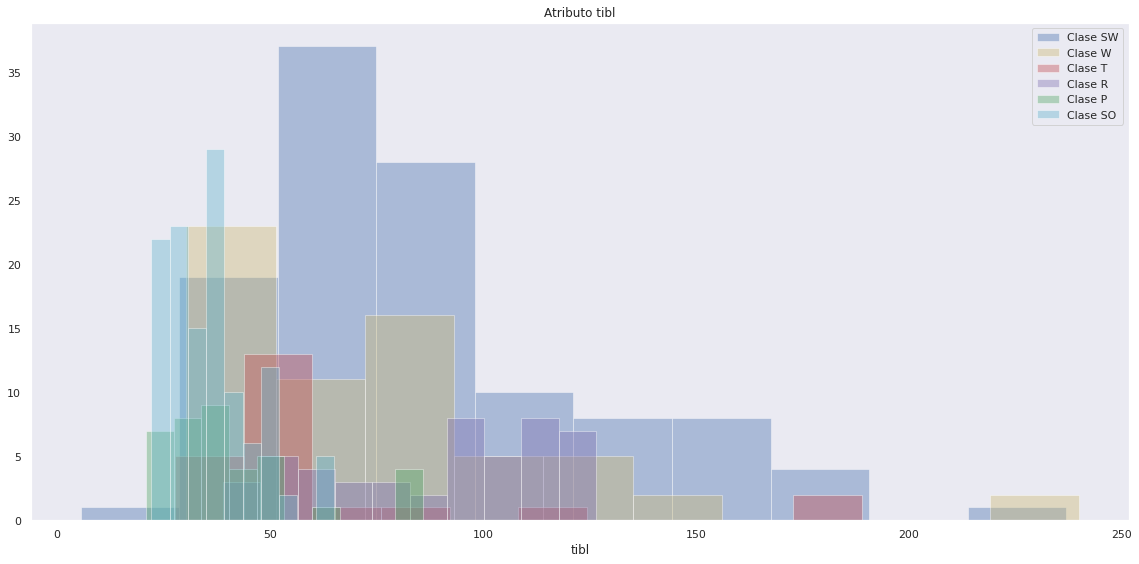

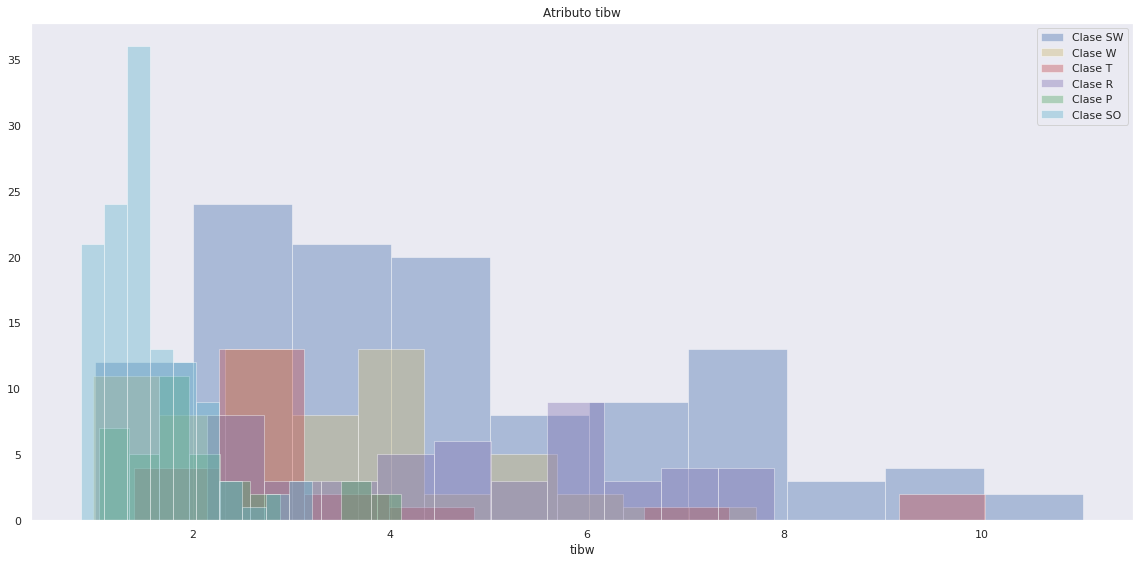

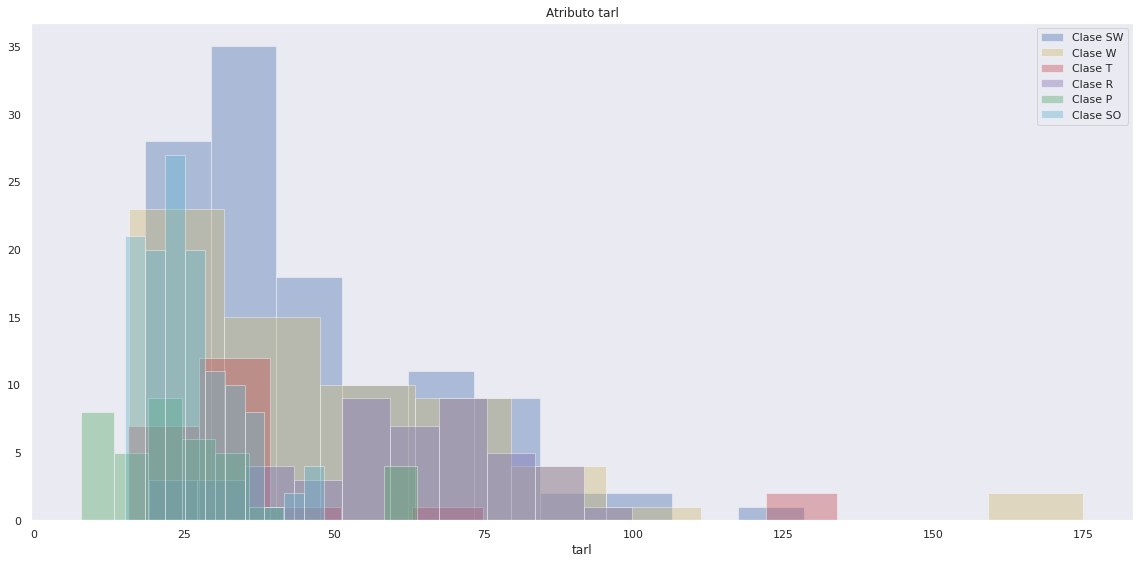

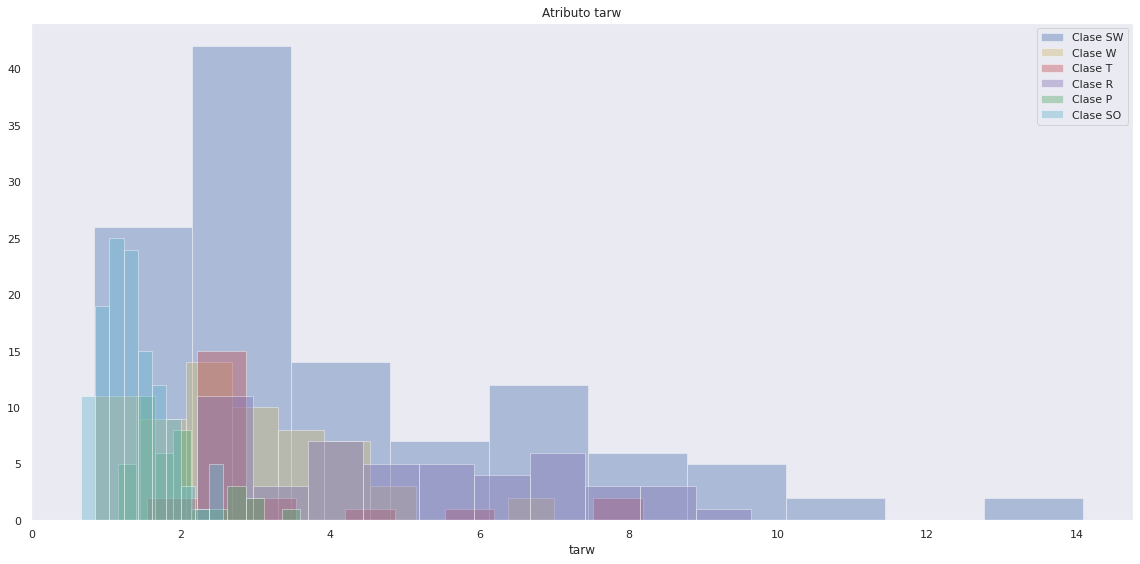

In [31]:
# Gráfico de barras para la distribución de atributos según cada clase

plt.rcParams['figure.figsize']=[16,8]                                   # Tamaño de figura
plt.suptitle('Variación de atributos según clase',size=20,y=1.1)        # Título

k = 1
for j in atributes:
  plt.subplot(1,1,k)
  plt.title('Atributo'+' '+j)
  sns.distplot(X[0][j], kde=False, label= 'Clase SW',bins=10)
  sns.distplot(X[1][j], kde=False, color="y", label= 'Clase W', bins=10)
  sns.distplot(X[2][j], kde=False, color="r", label= 'Clase T', bins=10)
  sns.distplot(X[3][j], kde=False, color="m", label= 'Clase R', bins=10)
  sns.distplot(X[4][j], kde=False, color="g", label= 'Clase P', bins=10)
  sns.distplot(X[5][j], kde=False, color="c", label= 'Clase SO', bins=10)
  plt.tight_layout()
  plt.grid()
  plt.legend()
  plt.show()


**Comentarios:**

En el gráfico de barras mostrado se puede ver que la distribución de cada atributo para todas las clases es muy similar. Para todos los atributos la clase SW es la predominante. Por otro lado, se ve que la clase SO se distribuye en un rango muy inferior en comparación a las otras clases.


**2.b Exploración y estandarización de datos**
* Separe los atributos del target según su clase como en el punto anterior.
* Separe luego los datos en Training set y Validation set, Con un 20% de los datos como validación y el resto como train. Asegúrese que se mantienen las proporciones de ejemplos de cada clase en ambos sets.
* ¿Qué ocurriría si por ejemplo todos los ejemplos de clase "R" quedaran en el validation set, qué haría cualquier máquina de aprendizaje? 
* Estandarice los datos.

In [92]:
x_tr, y_tr = df.drop(["type"],axis = 1), df["type"]
x_tr, x_val, y_tr, y_val = train_test_split(x_tr,y_tr,test_size = 0.2, shuffle = True)

print('Train set corresponde al',np.round(x_tr.shape[0]/df.shape[0]*100,2),'% de la data original')
print('Train set corresponde al',np.round(x_val.shape[0]/df.shape[0]*100,2),'% de la data original')

Train set corresponde al 79.9 % de la data original
Train set corresponde al 20.1 % de la data original


In [38]:
# Clases de tr para ver la distribución de clases en el train set
clases_tr = pd.DataFrame({'id':pd.concat([x_tr,y_tr],axis=1).index,
                          'Class':pd.concat([x_tr,y_tr],axis=1)['type']}).groupby('Class')['id'].nunique()

# Clases de val para ver la distribución de clases en el validation set
clases_val = pd.DataFrame({'id':pd.concat([x_val,y_val], axis= 1).index,
                           'Class':pd.concat([x_val,y_val], axis= 1)['type']}).groupby('Class')['id'].nunique()

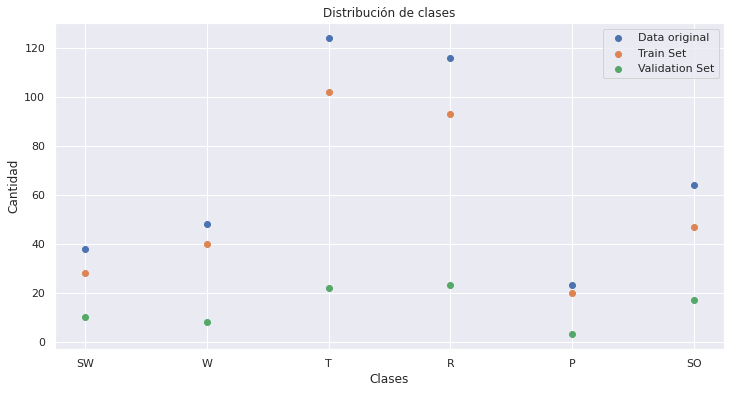

In [ ]:
# Gráfico de la distribución de las clases en data, train y validation set
plt.rcParams['figure.figsize']=[12,6]                   # Tamaño de figura

plt.scatter(types, clases,     label = 'Data original')
plt.scatter(types, clases_tr,  label = 'Train Set')
plt.scatter(types, clases_val, label = 'Validation Set')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.title('Distribución de clases')
plt.legend()

**Comentarios:**
En el gráfico se puede ver que tanto el train y validation set tiene una distribución similar de la cantidad de clases para cada conjunto respecto al dataset inicial. Solo difiere en la cantidad por razones obvias. 

In [39]:
# Estandarización de la variable
scaler_x = StandardScaler()
scaler_x.fit(x_tr.values)

# Variable x_tr
x_tr_st = scaler_x.transform(x_tr.values)

# Variable x_val 
x_val_st = scaler_x.transform(x_val.values)

#### 2.c Regresor logístico

Entrene un regresor logístico con los datos obteneidos en la pregunta anterior y calcule su desempeño (score por ahora) sobre los datos de validación. A priori le parece un buen desempeño?

In [40]:
# Regresión logística sin estandarizar
reg_log = LogisticRegression(random_state=0, multi_class="auto",
                             solver="lbfgs",max_iter=5000)
reg_log.fit(x_tr, y_tr)

# Regresión logística con estandarizar
reg_log_st = LogisticRegression(random_state=0, multi_class="auto",
                                solver="lbfgs",max_iter=5000)
reg_log_st.fit(x_tr_st, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Score
score_log    = reg_log.score(x_val,y_val)
score_log_st = reg_log_st.score(x_val_st, y_val)

print('Score para data sin estandarizar',score_log,'\n')
print('Score para data estandarizada', score_log_st)

Score para data sin estandarizar 0.9036144578313253 

Score para data estandarizada 0.7469879518072289


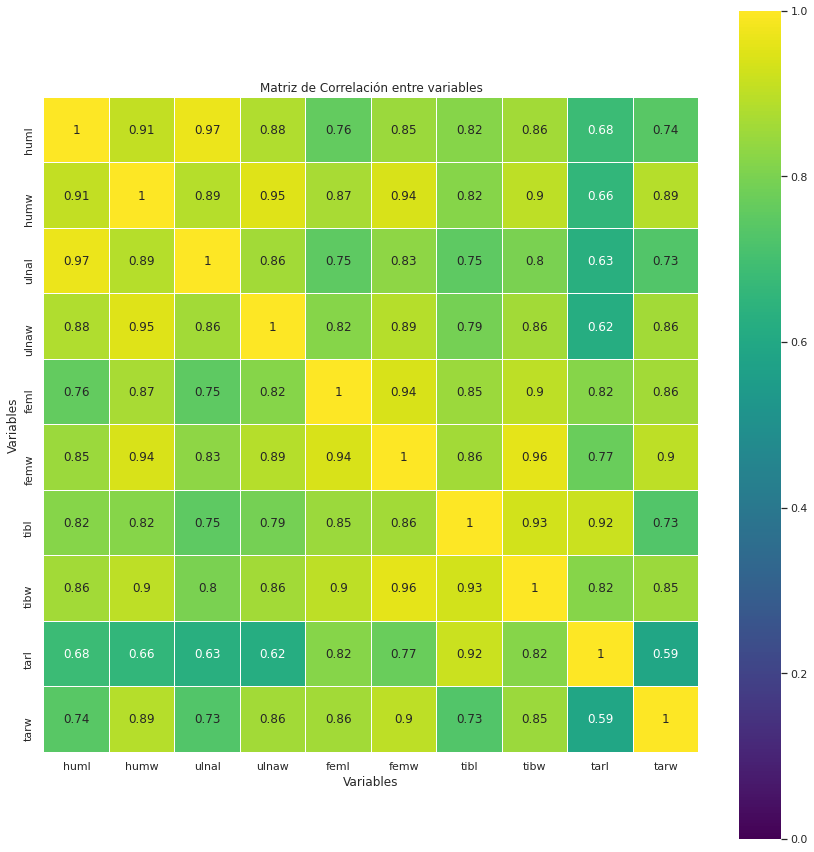

In [44]:
# Correlación con las variables estandarizadas
plt.figure(figsize=(12,12))                            #  Otro modo de controlar el tamaño del plot dentro del Notebook

sns.heatmap(np.around(pd.DataFrame(x_tr_st, columns = atributes).corr(),decimals=2), vmax=1,vmin=0, linewidths=0.1,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.tight_layout()
plt.ylabel('Variables')
plt.xlabel('Variables')
plt.title('Matriz de Correlación entre variables');
plt.show()

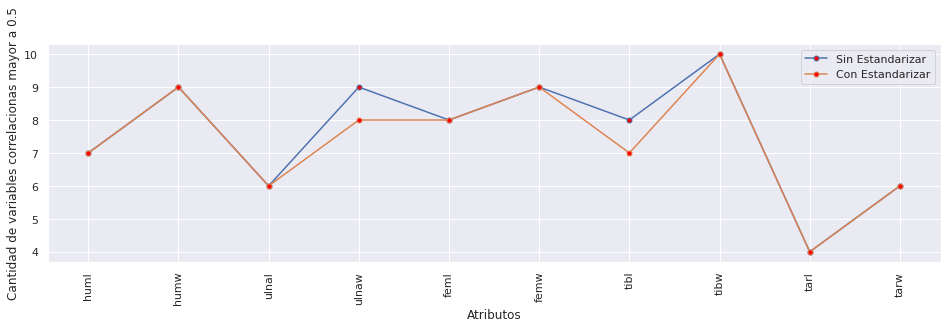

In [46]:
# Variables correlaciondas mayor a 0.8 para cada atributo
datacorr = pd.DataFrame(np.sum(np.around(df.iloc[:,:-1].corr(),decimals=2)>=0.8),columns=['Sin st'])
datacorr['Con st']=pd.DataFrame(np.sum(np.around(pd.DataFrame(x_tr_st, columns = atributes).corr(),decimals=2)>=0.8))
datacorr = datacorr.transpose()

#Gráfico de variables
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(datacorr.columns,datacorr.iloc[0,:],label='Sin Estandarizar', marker='o', ms=5, mfc='red')
plt.plot(datacorr.columns,datacorr.iloc[1,:],label='Con Estandarizar', marker='o', ms=5, mfc='red')
plt.xticks(rotation=90)
plt.xlabel('Atributos')
plt.ylabel('Cantidad de variables correlacionas mayor a 0.5')
plt.legend()

**Comentarios:**

Gracias al gráfico anterior, se ve con con la estandarización de las variables bajó la correlación entre las variables, lo que tambien ayuda a explicar la disminución del score.

#### 2.d Matriz de Confusión
Investigue un poco sobre los valores que conforman la matriz de confusión. Comente sobre la significancia de los distintos valores para el problema en cuestión. 

Escriba una función que a partir de un modelo o de los valores predecdos por un modelo, grafique la matriz de confusión.

In [47]:
def confusion(y_tr, x_tr, model, colormap ):
  matrix  = pd.DataFrame(confusion_matrix(y_tr, model.predict(x_tr)),
                         columns = types,index = types)
  return sns.heatmap(matrix,cmap = colormap, annot = True)

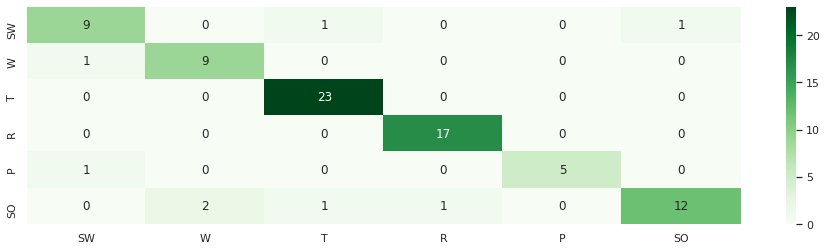

In [49]:
confusion(y_val, x_val, reg_log, "Greens")

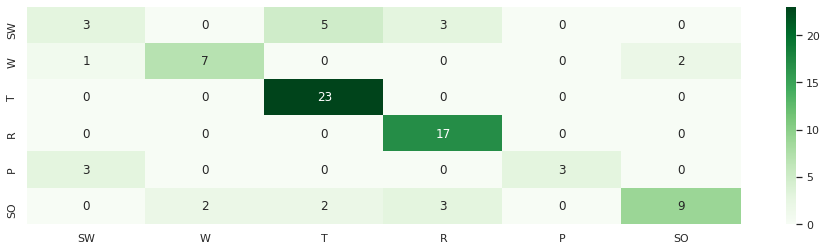

In [50]:
confusion(y_val, x_val_st, reg_log_st, "Greens")

**Comentarios:**

Mediante la matriz de confusión se puede ver que para ambas regresiones logisticas (estandarizadas y no estandarizadas) se obtiene la misma clasificación para las clases R y T. Mientras que para las otras clases existen una disminución en la cantidad de clasificaciones correctas.

#### 2.e Árbol de Clasificación

Entre un árbol de clasificación para tratar de resolver el problema. Pruebe unas cuantas profundidads máximas y elija una. Si quiere puede modificar los otros hiperparámetros del modelo.

Evalúe su desempeño respecto a los modelos lineales usando las métricas relevantes y compare su costo computacional. Discuta.

In [64]:
parameters = {'max_depth':[1,5,10,15,20,25,30],
              'min_samples_split': [2,5,10,15],
              'min_samples_leaf': [2,5,10,15]}
tree = GridSearchCV(DecisionTreeClassifier(criterion='gini'), param_grid = parameters, cv = 5)
tree.fit(x_tr, y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30],
            

In [65]:
print('Los mejores parámetros del árbol son:',tree.best_params_,'\n')
print('El score del árbol es',tree.score(x_val,y_val),'\n')
print('Reporte para árbol de clasificación \n')
print(classification_report(y_val,tree.predict(x_val)),'\n')
print('Reporte para regresión logística \n')
print( classification_report(y_val,reg_log.predict(x_val)),'\n')

Los mejores parámetros del árbol son: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2} 

El score del árbol es 0.7228915662650602 

Reporte para árbol de clasificación 

              precision    recall  f1-score   support

           P       0.62      0.73      0.67        11
           R       0.58      0.70      0.64        10
          SO       0.91      0.91      0.91        23
          SW       0.73      0.94      0.82        17
           T       0.00      0.00      0.00         6
           W       0.67      0.50      0.57        16

    accuracy                           0.72        83
   macro avg       0.58      0.63      0.60        83
weighted avg       0.68      0.72      0.70        83
 

Reporte para regresión logística 

              precision    recall  f1-score   support

           P       0.82      0.82      0.82        11
           R       0.82      0.90      0.86        10
          SO       0.92      1.00      0.96        23
          SW     

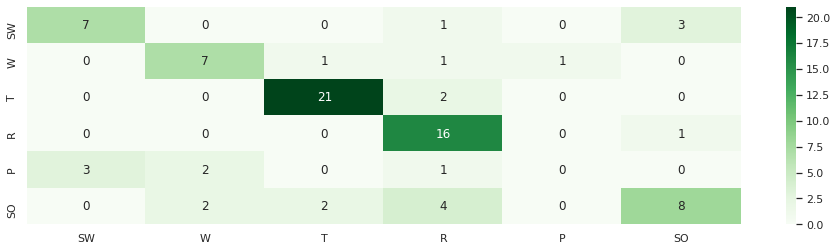

In [61]:
# Matriz de confusión para el árbol de clásificación
confusion(y_val, x_val, tree,  "Greens")

**Comentarios:**

Mediante el árbol de clasificación no mejora el ajuste en comparación a la regresión logistica sin estandarizar las variables. Esto se puede deber al desbalance de clases. Por otro lado, tambien es necesario mencionar que existe harta variabilidad lo que se ve reflejado en los mejores parámetros que se obtuvieron mediante cross validation.


#### 2.f Undersampling

Considerando que la gran mayoría del aprendizaje se realiza en los tipos "SO" y "SW", una aproximación para tratar de mejroar el desempeño de los modelos entrenados es simplemente reducir la cantidad de ejemplos de algunas clases para obtener los nuevos conjuntos de datos con clases más balanceadas. Así, el aprendizaje se realiza de manera más balanceada entre todas las clases y se logran extraer mejor los atributos de cada clase.

Complete la siguiente función capaz de hacer undersampling del conjunto de entrenamiento, se apreciarán versiones alternativas. Las validaciones deben realizarse sobre el conjnto de validación original ¿Por qué?. Mantener el parametro times que definirá el número de datos a borrar.

In [66]:
def undersample(x_tr, y_tr, times = 10):
  for i in range(times):                                             # Cantidad de elementos a eliminar
    SW_index = y_tr.index[y_tr == "SW"]                              # Guardar indice
    SO_index = y_tr.index[y_tr == "SO"]                              # Guardar indice
    delete   = np.random.choice(np.concatenate((SW_index,SO_index))) # Elige un número al azar para eliminar
    x_tr_u   = x_tr.drop([delete],axis=0)
    y_tr_u   = y_tr.drop([delete],axis=0)
  return x_tr_u, y_tr_u

**Comentarios** 

El undersampling se utiliza sobre el train set con el fin de que el modelo aprenda todas las caracteristicas importante del data set y no que tenga algun sesgo hacia la alguna clase, es decir, aprender más una clase que otra. Dicho esto, se debe ocupar el conjunto de validación original porque se debe comprobar que la máquina ha mejorar la capacidad de generalizar.

#### 2.i Entrenar con Undersampling

Pruebe distintos valores para el parámetros  `times` y evalúe si hay diferencias significativas en la matriz de confusión para el mismo árbol de clasificación entrenado anteriormente. Evidentemente el número de ejemplos de entrenamiento cambia a medida que cambia el parámetros  `times`, sin embargo nuestro interés no es qué tan bien se comporta el modelo sobre los datos de entrenamiento si no sobre los de validación, los cuales deben ser constantes a lo largo del análisis.

¿Cómo se comparan estos modelos con el modelo con todos los datos? (recuerde que las comparaciones deben hacerse calculando el desempeño sobre el conjunto de validación completo con el modelo una vez entrenado) ¿Ve alguna ventaja del uso de under sampling frente al uso de todos los datos?

In [67]:
# Distribución de clases inicial
clases

Class
P      38
R      48
SO    124
SW    116
T      23
W      64
Name: id, dtype: int64

**Comentarios** dado que la diferencia entre las clases es grande, se proponen valores de `times` grandes.


In [74]:
times      = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
score_tr   = []
score_val  = []
tree_times = DecisionTreeClassifier(criterion='gini',max_depth = 25,
                              min_samples_leaf = 2,min_samples_split = 2)

for i in times: 
  x_tr_u, y_tr_u = undersample(x_tr,y_tr,i)
  tree_times.fit(x_tr_u, y_tr_u)
  score_val.append(tree_times.score(x_val, y_val))

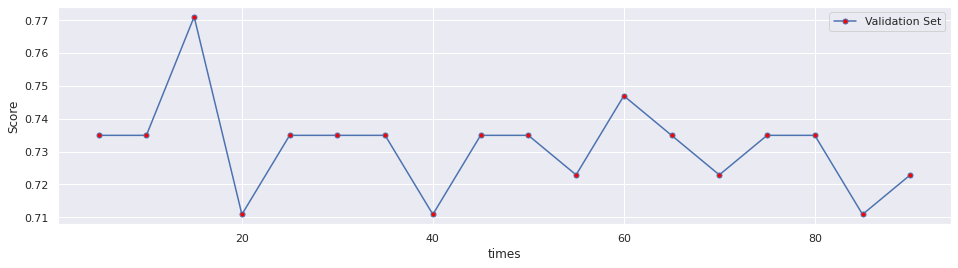

In [75]:
#Gráfico de variables
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(times,score_val, marker='o', ms=5, mfc='red', label = 'Validation Set')
plt.xlabel('times')
plt.ylabel('Score')
plt.legend()

**Comentarios:**

Se puede concluir que existe harta variabiliad aun cuando se utilice el método de undersampling. Cada vez que se itera el código se obtienen valores distinto, pero el rango de score es similar para todas las veces. Aún así no se ve una mejora a medida que se reduce la data.

#### 2.j Oversampling 

Otra aproximación para resolver el problema de las clases desbalanceadas es hacer _oversampling_. A partir de una muestra relativamente pequeña de ejemplos, en este caso de las clases distintas a "SW" y "SO", se busca crear un conjunto de datos más grande similar al inicial, que permita al modelo aprender las características de esa clase, buscando nuevamente obtener clases más balanceadas que originalmente, pero esta vez sin reducir la cantidad de ejemplos. Esta aproximación tiene la ventaja que no reduce la cantidad de ejemplos, pero trae la complicación de decidir cómo se van a crear los datos nuevos. 

Dos aproximaciones bastantes estandar son SMOTE y ADASYN. Investigue un poco que hace SMOTE y que diferencia implemente ADASYN. Por qué cree puede ser deseable buscar que los datos sintéticos no sean linealmente dependiente de los datos originales?

Elija alguno de los dos métodos e implementelo con el árbol entrenado previamente. Comente sobre el desempeño de tal modelo.

**SMOTE**

Este algoritmo es parametrizado con k_neighbors y el número de  nuevos puntos que se desea crear. 
- Primero selecciona aleatoriamente los puntos minoritarios.
- Después selecciona cualquierda de sus k_neighbors de la misma clase.
- Seleccciona aleatoriamente un valor de lambda (parámetro) en el rango de [0,1].
- Genera y coloca el nuevo punto en el vector entre los puntos que escogio como vecinos.

**ADASYN**

ADASYN es similar a SMOTE, de hecho se deriva de SMOTE. La diferencia está en que ADASYN sesgará el espacio muestral (es decir, la probabilidad de que se elija un punto en particular para la duplicación) hacia puntos que no se encuentran en vecindarios homogeneos.


In [78]:
smo = SMOTE()
x_tr_smo, y_tr_smo = smo.fit_resample(x_tr,y_tr)
data_smo   = pd.concat([pd.DataFrame(x_tr_smo,columns = atributes),pd.DataFrame(y_tr_smo,columns=['type'])], axis= 1)
clases_smo = pd.DataFrame({'id':data_smo.index,'Class':data_smo['type']}).groupby('Class')['id'].nunique()
clases_smo

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class
P     101
R     101
SO    101
SW    101
T     101
W     101
Name: id, dtype: int64

In [86]:
# Ajuste del árbol
parameters = {'max_depth':[1,5,10,15,20,25,30],
              'min_samples_split': [2,5,10,15],
              'min_samples_leaf': [2,5,10,15]}
tree_smo = GridSearchCV(DecisionTreeClassifier(criterion='gini'), param_grid=parameters, cv=5)
tree_smo.fit(x_tr_smo, y_tr_smo)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 15, 20, 25, 30],
            

In [88]:
print('Los mejores parámetros del árbol son:',tree_smo.best_params_,'\n')
print('El score del árbol es',tree_smo.score(x_val,y_val),'\n')
print(classification_report(y_val,tree_smo.predict(x_val)))

Los mejores parámetros del árbol son: {'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2} 

El score del árbol es 0.8554216867469879 

              precision    recall  f1-score   support

           P       0.73      0.73      0.73        11
           R       0.75      0.90      0.82        10
          SO       1.00      0.91      0.95        23
          SW       0.93      0.82      0.87        17
           T       0.83      0.83      0.83         6
           W       0.78      0.88      0.82        16

    accuracy                           0.86        83
   macro avg       0.84      0.85      0.84        83
weighted avg       0.87      0.86      0.86        83



**Comentarios:**

Se puede ver que utilizando la técnica de aumento de clase se obtiene un mejor ajuste sobre los datos, aumento el score respecto a los casos anteriores. De todas forma, el ajuste por regresión logística con los datos sin estandarizar se tiene un mejor ajuste.

Note que tanto SMOTE como ADASYN tienen muchos parámetros que podrían afectar la calidad de los datos generados. Se valorará un pequeño comentario sobre los parámetros de los métodos y qué representan en la heuristica utilizada. 

#### 2.k Redes Neuronales Feed Forward

Por último, probaremos utilizar una red neuronal densa sobre los datos aumentados. Las redes neuronales son una herramienta muy poderosa, pero comparativamente costosa frente a otros modelos. Entrenar una red neuronal puede resultar muy costoso computacionalmente, por su gran número de parámetros entrenables y por el caracter iterativo de su entrenamiento. Además, el gran número de parámetros hace que las redes neuronales sean particularmente sensibles a overfitting, por lo cual puede ser necesario tener grandes cantidades de datos para poder entrenar una red neuronal obteniendo desempeños que justifiquen su costo adicional.

Por esto, entrenaremos la red neuronal sobre los datos aumentados. Básese en el código para crear la red neuronal. Explique los parámetros que se pasan en cada etapa de su creación, para esto puede leer la documentación de keras. Finalmente, entrene "completamente" la red, es decir, hasta que se estanque el error de validación o comience a aumentar. ¿Cómo se compara la red frente a otros modelos, tanto en desempeño como en costo?

In [93]:
# Se transforma cada target de forma one vs all
# Es decir, para la clase SW se tiene [1,0,0,0,0,0]
y_tr_red  = pd.get_dummies(y_tr_smo).values
y_val_red = pd.get_dummies(y_val).values

In [123]:
model = Sequential()  

model.add(Dense(64, activation = 'relu'))       # Hidden Layer
model.add(Dense(6,   activation = 'softmax'))    # Output Layer
model.compile(optimizer = 'sgd',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model.fit(x_tr_smo, y_tr_red, epochs = 50, 
                    verbose=False, validation_data = (x_val.values,y_val_red))

In [124]:
# Resultados y parámetros
resultados_red = history.history
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 390       
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________


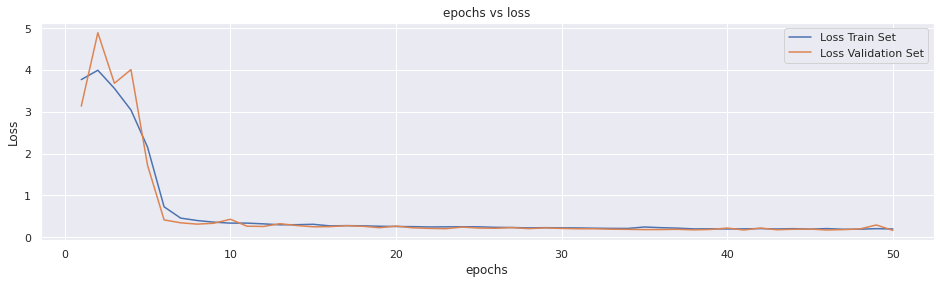

In [125]:
#Gráfico de Resultados de la red
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(np.arange(1,51,1),resultados_red['loss'], label = 'Loss Train Set')
plt.plot(np.arange(1,51,1),resultados_red['val_loss'], label = 'Loss Validation Set')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('epochs vs loss')
plt.legend()

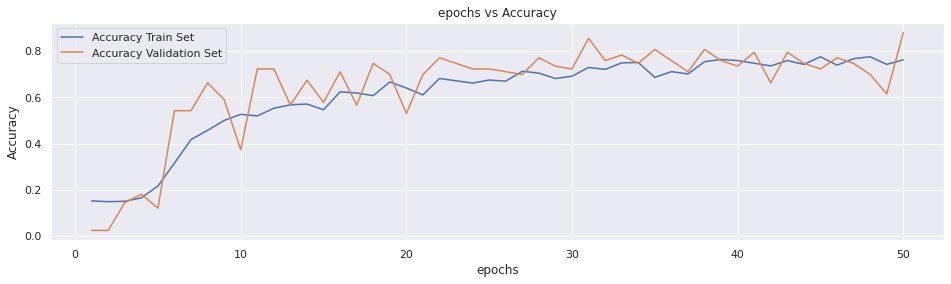

In [127]:
#Gráfico de Resultados de la red
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(np.arange(1,51,1),resultados_red['accuracy'], label = 'Accuracy Train Set')
plt.plot(np.arange(1,51,1),resultados_red['val_accuracy'], label = 'Accuracy Validation Set')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('epochs vs Accuracy')
plt.legend()

**Comentarios:** 

Para este caso, la red se comporta bastante bien en el sentido que a pensar de la cantida de parámetros entrenables se obtiene buenos resultados. El accuracy oscila dentro de los mismos valores para el caso de los diferentes árboles. La varianza que se tiene en la red es considerable dado que cada vez que se itera se obtienen resultados muy diferentes. En términos de tiempo, no es un factor a considerar dado que el cálculo es rápido. Por último acotar que el mejor score fue el de la regresión logística sin estandarizar.

In [129]:
# Estandarizando los datos aumentados
scaler_x_smo = StandardScaler()
scaler_x_smo.fit(x_tr_smo)

# Ajuste
x_tr_smo_st =scaler_x_smo.transform(x_tr_smo)

In [137]:
model2 = Sequential()  

model2.add(Dense(64, activation = 'relu'))       # Hidden Layer
model2.add(Dense(6,   activation = 'softmax'))    # Output Layer
model2.compile(optimizer = 'sgd',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model2.fit(x_tr_smo_st, y_tr_red, epochs = 50, 
                    verbose=False, validation_data = (x_val_st,y_val_red))

In [138]:
# Resultados y parámetros
resultados_red2 = history.history
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 390       
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________


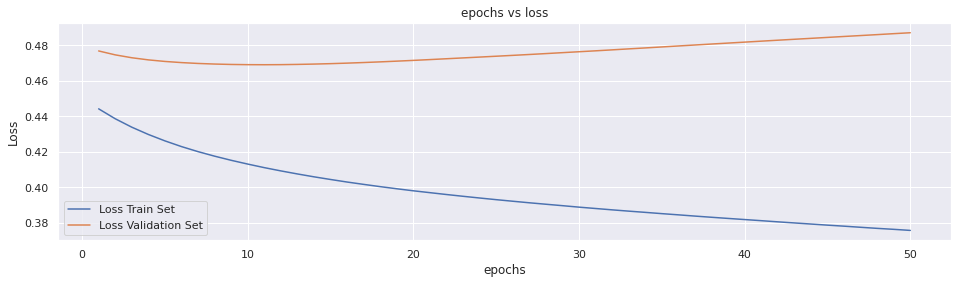

In [139]:
#Gráfico de Resultados de la red
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(np.arange(1,51,1),resultados_red2['loss'], label = 'Loss Train Set')
plt.plot(np.arange(1,51,1),resultados_red2['val_loss'], label = 'Loss Validation Set')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('epochs vs loss')
plt.legend()

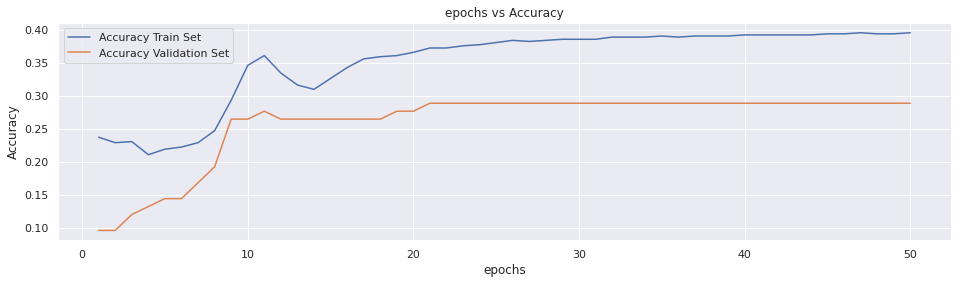

In [140]:
#Gráfico de Resultados de la red
plt.rcParams["figure.figsize"] = [16,4]
plt.plot(np.arange(1,51,1),resultados_red2['accuracy'], label = 'Accuracy Train Set')
plt.plot(np.arange(1,51,1),resultados_red2['val_accuracy'], label = 'Accuracy Validation Set')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('epochs vs Accuracy')
plt.legend()

**Comentarios:** 

Se puede apreciar que para los datos estandarizados, el comportamiento de la red es similar en cada iteración, pero en los gráficos se puede ver sobreajuste.
